In [1]:
from __future__ import division
import os
import numpy as np
import cv2
import random
import requests
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import nn

/home/alex/Programs/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
FACE_PATH = "/home/alex/Desktop/Face Detection/Face Detect/Positive/"
NON_FACE_PATH = "/home/alex/Desktop/Face Detection/Face Detect/Negative/"
IN_SIZE = (32,32)   #Input dimensions of image for the network
SNAP_COUNT = 5      #Number of random snapshots per non-face image
MIN_LEN = 10        #Minimum length for the random snaphsots of non-faces
GOOD = [1,0]
BAD = [0,1]

FACE_COUNT = 30000
TRAIN_SPLIT = int(0.7*FACE_COUNT)

SAVE_PATH = "/home/alex/Desktop/Face-Detection-Recognition/model/"

In [3]:
#Method to generate multiple snapshots from an image
def rand_snap(img):
    r = []
    x = img.shape[0]
    y = img.shape[1]
    #Generate 5 snapshots of different sizes
    for i in range(SNAP_COUNT):
        snap_size = max([MIN_LEN,int(random.random()*200)])
        fx = int(random.random()*(x-snap_size))
        fy = int(random.random()*(y-snap_size))
        snap = img[fx:fx+snap_size,fy:fy+snap_size]
        r.append(cv2.resize(snap,IN_SIZE))
    return r

#Load the dataset for face/non face classification
def load_find_ds():
    ds = []
    #Load faces (positive samples)
    for n in os.listdir(FACE_PATH):
        name = FACE_PATH+n
        for img_path in os.listdir(name):
            t_img = cv2.resize(cv2.imread(name+"/"+img_path,0),IN_SIZE)
            ds.append((t_img, GOOD))
            ds.append((cv2.flip(t_img,1),GOOD)) #Use the horizontal mirror image
    random.shuffle(ds)
    ds = ds[:FACE_COUNT] 
    #Load non-faces (negative samples) from dataset
    nface_ds = []
    for n in os.listdir(NON_FACE_PATH):
        name = NON_FACE_PATH+n
        for img_path in os.listdir(name):
            t_img = cv2.imread(name+"/"+img_path,0)
            nface_ds.extend([(r,BAD) for r in rand_snap(t_img)])
            nface_ds.append((cv2.resize(t_img, IN_SIZE),BAD))
    random.shuffle(nface_ds)
    nface_ds = nface_ds[:FACE_COUNT]

    #Make the train, val and test sets: Ensure 50% for each set
    train = ds[:TRAIN_SPLIT]
    train.extend(nface_ds[:TRAIN_SPLIT])
    random.shuffle(train)
    test = ds[TRAIN_SPLIT:]
    test.extend(nface_ds[TRAIN_SPLIT:])
    random.shuffle(test)

    trainX,trainY = map(np.array,zip(*train))
    testX,testY = map(np.array,zip(*test))

    return ((trainX,trainY),(testX,testY))

In [4]:
((trainX,trainY),(testX,testY)) = load_find_ds()

In [5]:
print(trainX.shape)
print(testX.shape)

(42000, 32, 32)
(18000, 32, 32)


In [6]:
sum(trainY)+sum(testY)

array([30000, 30000])

In [7]:
#Build the net in the session
def build_net(sess):
    in_len = 32
    in_dep = 1

    x_hold = tf.placeholder(tf.float32,shape=[None,in_dep*in_len*in_len])
    y_hold = tf.placeholder(tf.float32,shape=[None,2])
    keep_prob = tf.placeholder(tf.float32)

    xt = tf.reshape(x_hold,[-1,in_len,in_len,in_dep])

    xt = tf.layers.batch_normalization(xt)
    
    #Layer 1 - 3x3 convolution
    w1 = tf.Variable(tf.truncated_normal([3,3,in_dep,4], stddev=0.1))
    b1 = tf.Variable(tf.constant(0.1, shape=[4]))
    c1 = nn.relu(nn.conv2d(xt,w1,strides=[1,2,2,1],padding='VALID')+b1)
    o1 = nn.max_pool(c1, [1,2,2,1], [1,2,2,1], padding='VALID')
    #o1 = tf.layers.batch_normalization(o1)
    
    print("o1 shape: {}".format(o1.shape))
    
    #Layer 2 - 3x3 convolution
    w2 = tf.Variable(tf.truncated_normal([3,3,4,16], stddev=0.1))
    b2 = tf.Variable(tf.constant(0.1, shape=[16]))
    c2 = nn.relu(nn.conv2d(o1,w2,strides=[1,2,2,1],padding='VALID')+b2)
    o2 = c2
    print("o2 shape: {}".format(o2.shape))
    
    #o3 = o2
    
    #Layer 3 - 3x3 convolution
    w3 = tf.Variable(tf.truncated_normal([3,3,16,32], stddev=0.1))
    b3 = tf.Variable(tf.constant(0.1, shape=[32]))
    c3 = nn.relu(nn.conv2d(o2,w3,strides=[1,1,1,1],padding='VALID')+b3)
    o3 = o2
 
    print("o3 shape: {}".format(o3.shape))
    
    
    dim = 9*4*4
        
    #Fully connected layer - 600 units
    of = tf.reshape(o3,[-1,dim])
    w4 = tf.Variable(tf.truncated_normal([dim,600], stddev=0.1))
    b4 = tf.Variable(tf.constant(0.1, shape=[600]))
    o4 = nn.relu(tf.matmul(of,w4)+b4)

    o4 = nn.dropout(o4, keep_prob)

    print("o4 shape: {}".format(o4.shape))
    
    
    
    #Output softmax layer - 2 units
    w5 = tf.Variable(tf.truncated_normal([600,2], stddev=0.1))
    b5 = tf.Variable(tf.constant(0.1, shape=[2]))
    y = nn.softmax(tf.matmul(o4,w5)+b5)

    sess.run(tf.global_variables_initializer())

    return y,x_hold,y_hold,keep_prob

In [8]:
#Finds the product of a dimension tuple to find the total legth
def dim_prod(dim_arr):
    return np.prod([d for d in dim_arr if d != None])

#Split to mini batches
def batchify(X, Y, batch_size):
    batches = [(X[i:i+batch_size],Y[i:i+batch_size]) for i in range(0,X.shape[0],batch_size)]
    random.shuffle(batches)
    return batches

In [10]:
#Start a TensorFlow session
def start_sess():
    config = tf.ConfigProto()
    config.gpu_options.allocator_type = 'BFC'
    sess = tf.Session(config=config)
    return sess

#Train the model
def ftrain(sess, y, x_hold, y_hold, keep_prob, X, Y, testX, testY, lrate=0.5, epsilon=1e-8, n_epoch=100, batch_size=10, print_epoch=100, save_path=None, plot_acc=None):
    cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_hold*tf.log(y+1e-10), reduction_indices=[1]))
    
    correct_prediction = tf.equal(tf.argmax(y,1),tf.argmax(y_hold,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    acc_X = []
    acc_Y = []
    
    train_step = tf.train.AdamOptimizer(learning_rate=lrate,epsilon=epsilon).minimize(cross_entropy)
    
    #Flatten the input images for the placeholder
    flat_len = dim_prod(x_hold._shape_as_list())
    X = X.reshape((X.shape[0],flat_len))

    print('Starting training session...')

    sess.run(tf.global_variables_initializer())
    batch_num = 0
    batches = batchify(X,Y,batch_size)
    print('Number of batches:',len(batches))
    for i in range(n_epoch):
        avg_acc = 0
        random.shuffle(batches)
        for batchX,batchY in batches:
            train_accuracy = accuracy.eval(session=sess, feed_dict={x_hold:batchX, y_hold:batchY, keep_prob:1})
            avg_acc = avg_acc + train_accuracy
            train_step.run(session=sess,feed_dict={x_hold:batchX, y_hold:batchY, keep_prob:0.75})
            #print('Epoch '+': '+str(train_accuracy))
        print('Epoch '+str(i)+': '+str(avg_acc/len(batches)))

        if (not testX is None) & (not testY is None):
            testX = testX.reshape((testX.shape[0],flat_len))
            test_accuracy = accuracy.eval(session=sess,feed_dict={x_hold:testX, y_hold:testY, keep_prob:1})
            #print('Acc test: ',test_accuracy)
            if plot_acc is not None:
                acc_Y.append(test_accuracy)
                acc_X.append(i)

    if not save_path is None:
        saver = tf.train.Saver()
        saver.save(sess, "/home/alex/Desktop/Face Detection/Face Detect/test_model/tm", global_step=1000)
        #merged = tf.summary.merge_all()
        #writer = tf.train.SummaryWriter(save_path+'_graph',sess.graph)
        #writer.flush()
        #writer.close()
        print('Model saved')
        
    if plot_acc is not None:
        plt.plot(acc_X, acc_Y, 'r')
        plt.show()
        
    return test_accuracy

In [11]:
#Method to run the training
def train_net():
    train,test = load_find_ds()
    sess = start_sess()
    y,x_hold,y_hold,keep_prob = build_net(sess)
    acc = ftrain(sess,
                y,
                x_hold,
                y_hold,
                keep_prob,
                train[0],train[1],
                test[0],test[1],
                lrate=1e-4,
                epsilon=1e-16,
                n_epoch=50,
                batch_size=100,
                print_epoch=1,
                save_path=True,
                plot_acc=True)
    print("Accuracy:",acc)
    sess.close()

o1 shape: (?, 7, 7, 4)
o2 shape: (?, 3, 3, 16)
o3 shape: (?, 3, 3, 16)
o4 shape: (?, 600)
Starting training session...
Number of batches: 420
Epoch 0: 0.8619285716187386
Epoch 1: 0.9474523819628216
Epoch 2: 0.9625476242530914
Epoch 3: 0.9689523878551665
Epoch 4: 0.974571438630422
Epoch 5: 0.9786904872882933
Epoch 6: 0.9813571545339766
Epoch 7: 0.9839523914314452
Epoch 8: 0.9861428672359103
Epoch 9: 0.9874047710782006
Epoch 10: 0.9888333421377908
Epoch 11: 0.990190483984493
Epoch 12: 0.9913333408889317
Epoch 13: 0.9919523880595252
Epoch 14: 0.9928095302411488
Epoch 15: 0.9934285775536582
Epoch 16: 0.9941428627286638
Epoch 17: 0.9948571476198378
Epoch 18: 0.9953095282827105
Epoch 19: 0.9958809563091823
Epoch 20: 0.9964047651915323
Epoch 21: 0.9966904793466841
Epoch 22: 0.9970000027191072
Epoch 23: 0.9971904788698469
Epoch 24: 0.9978095258985247
Epoch 25: 0.9981428589139666
Epoch 26: 0.9977142878941128
Epoch 27: 0.9983333349227905
Epoch 28: 0.9984047634260995
Epoch 29: 0.9984047634260995


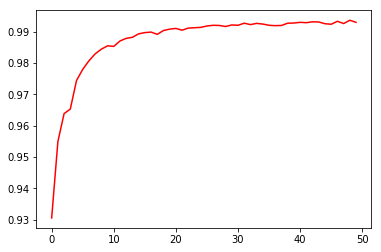

Accuracy: 0.993


In [12]:
train_net()